In [1]:
# 04_tempo_free_team_metrics.ipynb
# ⏱️ Tempo-Free Team Metrics

# Requirements: pandas, matplotlib, seaborn (install via `pip install pandas matplotlib seaborn`)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display

DATA_DIR = Path("./data")

plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = [14, 7]
sns.set_palette("rocket")
pd.options.display.float_format = "{:.2f}".format

print("Data directory:", DATA_DIR.resolve())


Data directory: /home/bluescar/jupyter/cbb/starter_pack/artifacts/data


# 🎯 What You'll Explore

> **Beginner tip:** Tempo-free stats remove pace differences so you can compare teams fairly. After each section, write a quick note about what changed—that habit builds intuition fast.

Tempo-free stats strip away raw scoring totals so you can compare teams on a per-possession basis. In this notebook you will:
- audit which seasons are available in the packaged data
- load team-season summaries and derive offensive/defensive efficiency
- visualize pace vs. efficiency and the balance between offense and defense
- benchmark Four Factors performance against the national baseline
- segment teams into pace tiers and compare how tempo relates to net rating


In [2]:
# 📅 Discover available seasons
season_files = sorted(p.stem for p in (DATA_DIR / "team_season_stats").glob('*.csv'))
print(f"Available seasons ({len(season_files)}):")
print(', '.join(season_files[:10]))
if len(season_files) > 10:
    print('…')
    print(', '.join(season_files[-5:]))


Available seasons (21):
2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014
…
2021, 2022, 2023, 2024, 2025


## 🛠️ Set analysis parameters
Unsure what to enter? Keep the defaults and rerun later with your favorite conference. Consistency in the parameters helps you spot changes across notebooks.

Choose the season (and optional conference) to analyze, then rerun the notebook.


In [3]:
# 🔁 Parameters
TARGET_SEASON = 2025  # replace with any available season above
TARGET_CONFERENCE = None  # e.g. 'Big Ten' or None for all conferences

print(f"Analyzing season: {TARGET_SEASON}")
print(f"Conference filter: {TARGET_CONFERENCE or 'All'}")


Analyzing season: 2025
Conference filter: All


In [5]:
# 📥 Load team season stats
team_season_path = DATA_DIR / 'team_season_stats' / f'{TARGET_SEASON}.csv'
team_season = pd.read_csv(team_season_path)

if TARGET_CONFERENCE:
    team_season = team_season[team_season['conference'] == TARGET_CONFERENCE].copy()

print(f"Rows loaded: {len(team_season):,}")
display(team_season.head())


Rows loaded: 364


,season,seasonLabel,teamId,team,conference,games,wins,losses,totalMinutes,pace,...,opponentStats_fourFactors_freeThrowRate,opponentStats_fourFactors_offensiveReboundPct,opponentStats_fourFactors_turnoverRatio,opponentStats_fourFactors_effectiveFieldGoalPct,opponentStats_assists,opponentStats_blocks,opponentStats_steals,opponentStats_possessions,opponentStats_rating,opponentStats_trueShooting
0,2025,20242025,1,Abilene Christian,WAC,32,16,16,1310,66.40,...,49.30,29.10,0.25,50.00,383,143,259,2172,103.50,55.20
1,2025,20242025,2,Air Force,Mountain West,32,4,28,1310,61.10,...,35.40,26.80,0.16,54.60,410,103,217,1999,117.90,58.00
2,2025,20242025,3,Akron,MAC,35,28,7,1415,69.10,...,32.10,30.60,0.18,49.40,418,88,246,2445,107.40,53.30
3,2025,20242025,4,Alabama A&M,SWAC,32,10,22,1320,61.50,...,47.00,30.90,0.25,53.10,484,97,289,2025,124.50,57.50
4,2025,20242025,5,Alabama,SEC,37,28,9,1510,74.50,...,33.20,33.90,0.14,47.80,480,153,288,2813,106.90,52.00


## 📊 Build tempo-free metrics
The dataset includes pre-calculated tempo-free metrics that adjust for pace of play. These per-possession statistics allow fair comparisons between teams regardless of how fast or slow they play, with Four Factors breaking down the key components of basketball success.


In [6]:
# 🔢 Derive headline metrics
tempo_metrics = (
    team_season
    .assign(
        off_rating=lambda df: df['teamStats_rating'],
        def_rating=lambda df: df['opponentStats_rating'],
        net_rating=lambda df: df['teamStats_rating'] - df['opponentStats_rating'],
        off_efg=lambda df: df['teamStats_fourFactors_effectiveFieldGoalPct'],
        def_efg=lambda df: df['opponentStats_fourFactors_effectiveFieldGoalPct'],
        off_tov=lambda df: df['teamStats_fourFactors_turnoverRatio'],
        def_tov=lambda df: df['opponentStats_fourFactors_turnoverRatio'],
        off_orb=lambda df: df['teamStats_fourFactors_offensiveReboundPct'],
        def_orb=lambda df: df['opponentStats_fourFactors_offensiveReboundPct'],
        off_ftr=lambda df: df['teamStats_fourFactors_freeThrowRate'],
        def_ftr=lambda df: df['opponentStats_fourFactors_freeThrowRate'],
        true_shooting=lambda df: df['teamStats_trueShooting'],
    )
)
tempo_metrics = tempo_metrics[[
    'team', 'conference', 'games', 'wins', 'pace', 'off_rating', 'def_rating', 'net_rating',
    'off_efg', 'def_efg', 'off_tov', 'def_tov', 'off_orb', 'def_orb', 'off_ftr', 'def_ftr', 'true_shooting'
]]
tempo_metrics.head()


,team,conference,games,wins,pace,off_rating,def_rating,net_rating,off_efg,def_efg,off_tov,def_tov,off_orb,def_orb,off_ftr,def_ftr,true_shooting
0,Abilene Christian,WAC,32,16,66.40,103.80,103.50,0.30,48.30,50.00,0.22,0.25,32.90,29.10,36.10,49.30,52.90
1,Air Force,Mountain West,32,4,61.10,98.90,117.90,-19.00,50.10,54.60,0.22,0.16,24.70,26.80,35.40,35.40,53.10
2,Akron,MAC,35,28,69.10,120.50,107.40,13.10,55.20,49.40,0.17,0.18,30.70,30.60,26.10,32.10,58.40
3,Alabama A&M,SWAC,32,10,61.50,114.70,124.50,-9.80,47.00,53.10,0.25,0.25,38.10,30.90,37.50,47.00,51.00
4,Alabama,SEC,37,28,74.50,119.30,106.90,12.40,56.60,47.80,0.17,0.14,29.30,33.90,39.30,33.20,60.30


In [6]:
# 🥇 Top teams by net rating
top_net = tempo_metrics.sort_values('net_rating', ascending=False).head(10)
display(top_net[['team', 'conference', 'pace', 'off_rating', 'def_rating', 'net_rating']])


,team,conference,pace,off_rating,def_rating,net_rating
71,Duke,ACC,65.70,126.70,95.40,31.30
309,UC San Diego,Big West,63.10,125.90,97.90,28.00
101,Gonzaga,WCC,67.30,124.50,100.60,23.90
112,Houston,Big 12,60.50,116.90,93.30,23.60
86,Florida,SEC,68.10,124.70,102.20,22.50
332,VCU,A-10,63.80,119.40,97.30,22.10
159,Maryland,Big Ten,67.10,119.70,98.80,20.90
69,Drake,MVC,50.70,130.90,110.10,20.80
161,McNeese,Southland,59.70,128.50,107.80,20.70
15,Auburn,SEC,67.50,121.60,101.80,19.80


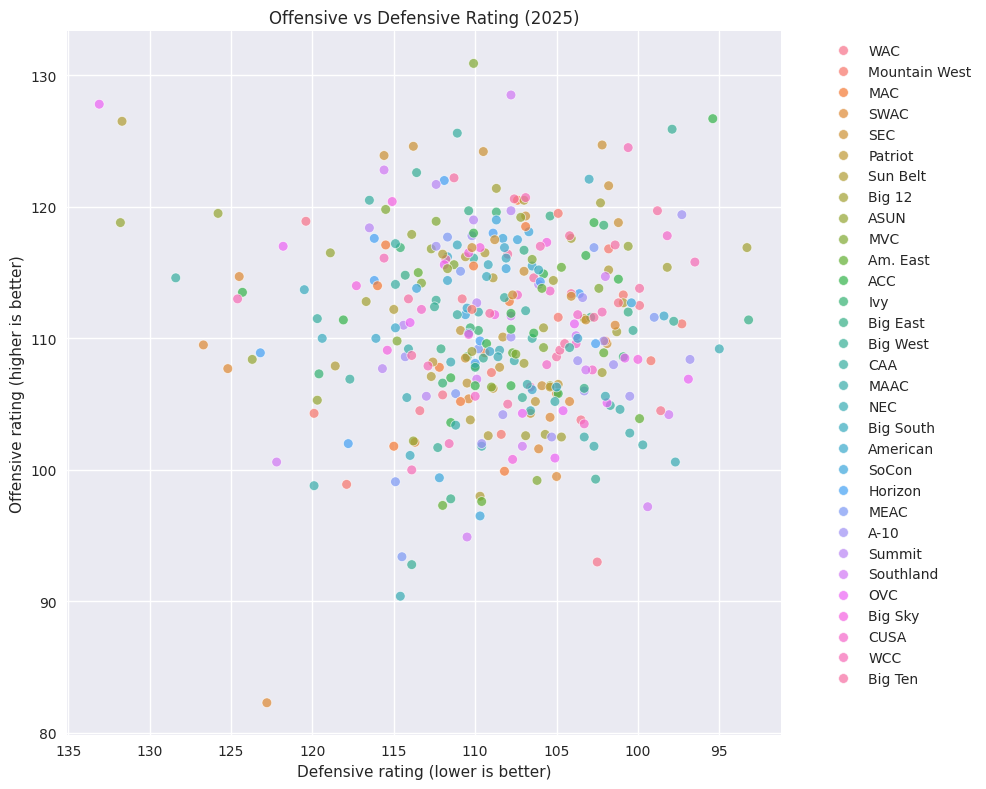

In [7]:
# ⚖️ Offense vs. defense balance
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=tempo_metrics, x='def_rating', y='off_rating', hue='conference', alpha=0.7, ax=ax)
ax.invert_xaxis()  # lower defensive rating (to the right) is better
ax.set_title(f'Offensive vs Defensive Rating ({TARGET_SEASON})')
ax.set_xlabel('Defensive rating (lower is better)')
ax.set_ylabel('Offensive rating (higher is better)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


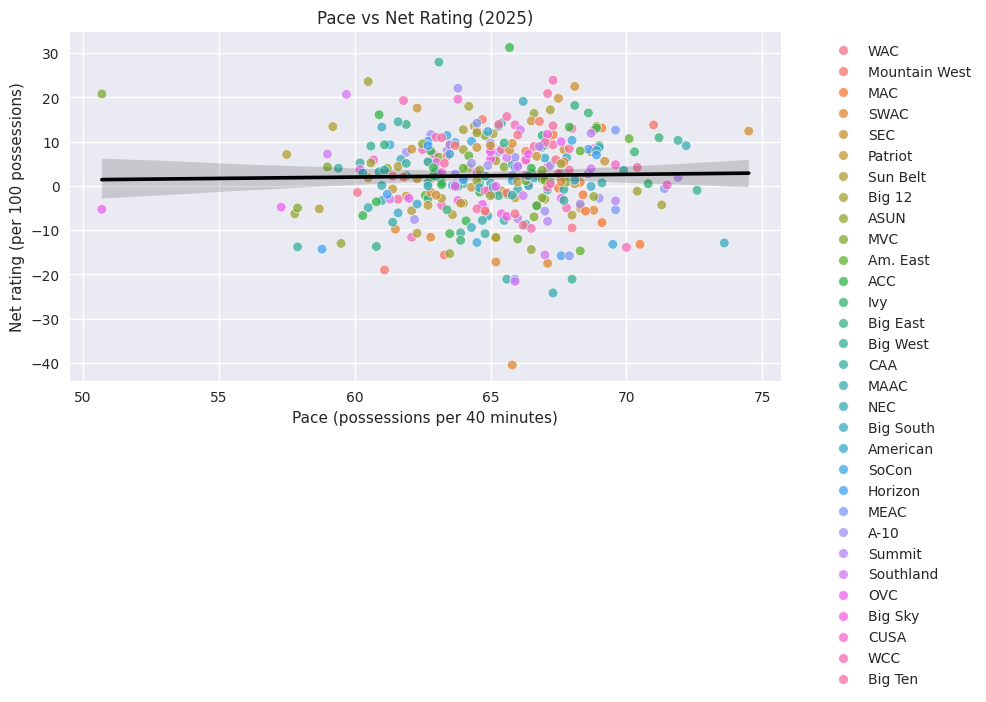

In [8]:
# ⏱️ Pace vs net rating
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(data=tempo_metrics, x='pace', y='net_rating', hue='conference', alpha=0.75, ax=ax)
sns.regplot(data=tempo_metrics, x='pace', y='net_rating', scatter=False, color='black', ax=ax)
ax.set_title(f'Pace vs Net Rating ({TARGET_SEASON})')
ax.set_xlabel('Pace (possessions per 40 minutes)')
ax.set_ylabel('Net rating (per 100 possessions)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## 📐 Four Factors profile
Four Factors highlight shooting, turnovers, rebounding, and free throws. Compare a top team and a middle-of-the-pack team to see which factor separates them.

Compare how elite teams perform on the Four Factors relative to the national baseline. Positive values mean better-than-average results (turnover and defensive metrics are flipped so higher is better).


,off_efg,off_tov,off_orb,off_ftr,def_efg,def_tov,def_orb,def_ftr
team,,,,,,,,
Duke,6.59,0.04,-1.85,0.04,6.03,0.01,-3.52,7.69
UC San Diego,4.19,0.04,-2.95,-0.66,3.43,-0.07,2.18,3.69
Gonzaga,4.69,0.04,-0.95,-2.16,2.93,0.00,-0.72,3.39
Houston,0.39,0.04,4.95,-5.66,5.63,-0.03,-0.82,-1.51
Florida,3.59,0.02,3.05,2.04,4.93,0.01,-4.62,0.19


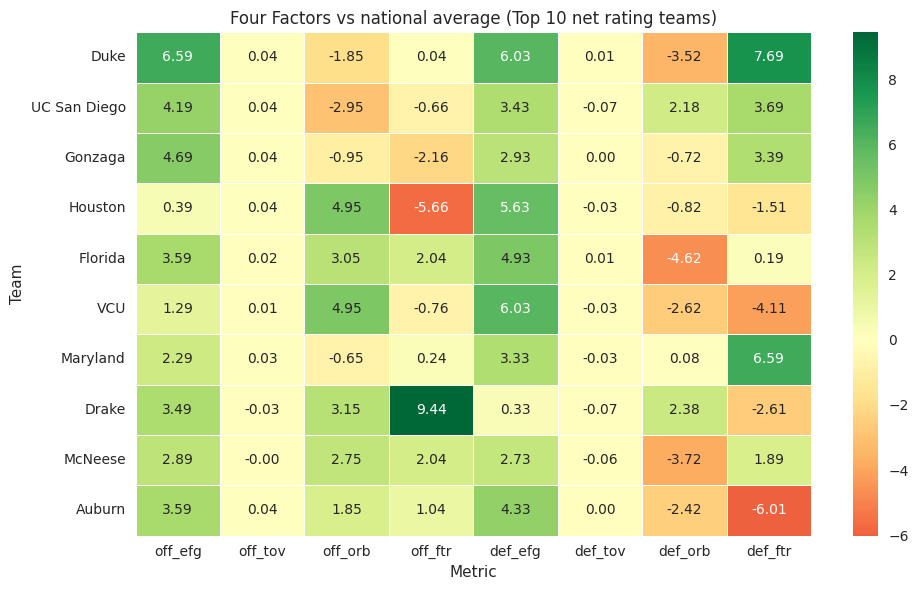

In [8]:
# 🔎 Compute differences from the national average
four_factor_cols = ['off_efg', 'off_tov', 'off_orb', 'off_ftr', 'def_efg', 'def_tov', 'def_orb', 'def_ftr']
baseline = tempo_metrics[four_factor_cols].mean()
top_four = tempo_metrics.nlargest(10, 'net_rating').set_index('team')[four_factor_cols]

def adjust(col_name, series):
    invert_cols = {'off_tov', 'def_efg', 'def_tov', 'def_orb', 'def_ftr'}
    if col_name in invert_cols:
        return baseline[col_name] - series
    return series - baseline[col_name]

adjusted = pd.DataFrame({col: adjust(col, top_four[col]) for col in top_four.columns})
display(adjusted.head())

plt.figure(figsize=(10, 6))
sns.heatmap(adjusted, cmap='RdYlGn', center=0, linewidths=0.5, annot=True, fmt='.2f')
plt.title('Four Factors vs national average (Top 10 net rating teams)')
plt.xlabel('Metric')
plt.ylabel('Team')
plt.tight_layout()
plt.show()


## 🏃 Pace tiers
The pace buckets translate raw numbers into plain labels (slow, medium, fast). Think about how a team's tempo might change the way you game-plan against them.

Group teams into pace buckets to see how style of play correlates with efficiency.


In [9]:
# 🪜 Build pace buckets
pace_bins = [0, 55, 65, 70, 100]
pace_labels = ['<55', '55-65', '65-70', '70+']
pace_view = tempo_metrics.assign(
    pace_bucket=pd.cut(tempo_metrics['pace'], bins=pace_bins, labels=pace_labels, include_lowest=True)
)

pace_summary = (
    pace_view
    .groupby('pace_bucket', dropna=False, as_index=False)
    .agg(
        teams=('team', 'count'),
        avg_pace=('pace', 'mean'),
        avg_off_rating=('off_rating', 'mean'),
        avg_def_rating=('def_rating', 'mean'),
        avg_net_rating=('net_rating', 'mean')
    )
)
display(pace_summary)


/tmp/ipykernel_480939/1613927386.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('pace_bucket', dropna=False, as_index=False)


,pace_bucket,teams,avg_pace,avg_off_rating,avg_def_rating,avg_net_rating
0,<55,2,50.70,129.35,121.60,7.75
1,55-65,170,62.68,112.14,109.83,2.31
2,65-70,175,67.07,109.57,107.37,2.19
3,70+,17,71.51,110.63,107.78,2.85


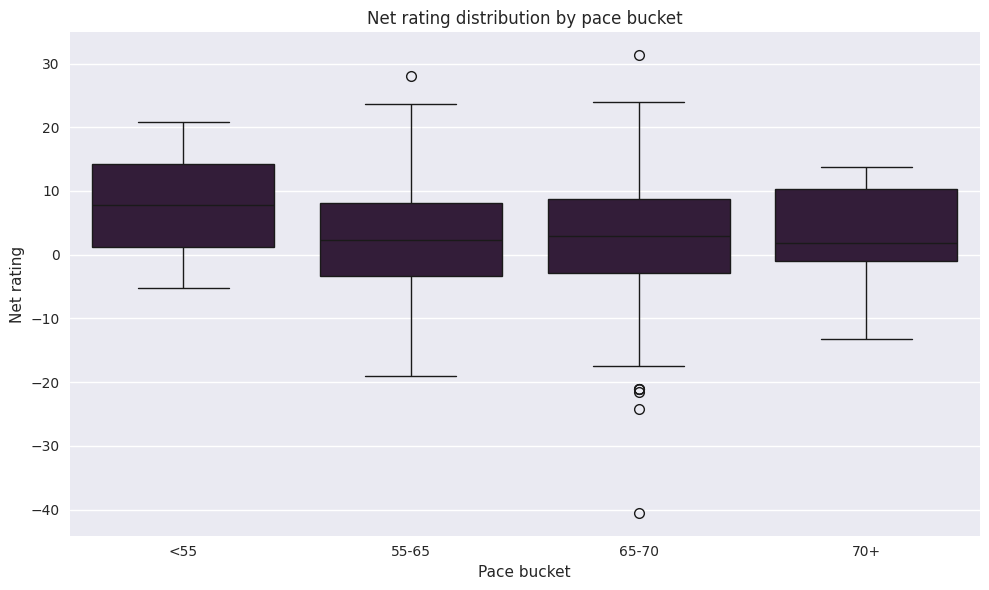

In [23]:
# 📦 Net rating distribution by pace bucket
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=pace_view, x='pace_bucket', y='net_rating', ax=ax)
ax.set_title('Net rating distribution by pace bucket')
ax.set_xlabel('Pace bucket')
ax.set_ylabel('Net rating')
plt.tight_layout()
plt.show()


## ✅ Where to go next
Take the insights from this notebook into scouting reports—you now know whether a team wins through shooting, turnover pressure, or something else.

- Blend in `team_season_shooting_stats` to see how shot selection fuels each Four Factor.
- Repeat the analysis for a single conference (e.g., power leagues vs mid-majors).
- Pair this with `03_team_stats_explorer.ipynb` to connect tempo insights to location splits and matchup scouting.
